C:\Users\Kevin Nathanael\AppData\Local\Temp\ipykernel_21016\2537976233.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 53.4709, test RMSE 47.6819
Epoch 100: train RMSE 36.3938, test RMSE 29.3216
Epoch 200: train RMSE 29.1944, test RMSE 25.1712
Epoch 300: train RMSE 25.5509, test RMSE 24.1443
Epoch 400: train RMSE 23.7443, test RMSE 24.0285
Epoch 500: train RMSE 22.8868, test RMSE 24.2657
Epoch 600: train RMSE 22.5074, test RMSE 24.3971
Epoch 700: train RMSE 22.3630, test RMSE 24.8844
Epoch 800: train RMSE 22.2904, test RMSE 24.7094
Epoch 900: train RMSE 22.2646, test RMSE 24.7678
Epoch 1000: train RMSE 22.2528, test RMSE 24.8497
Epoch 1100: train RMSE 22.2422, test RMSE 24.8002
Epoch 1200: train RMSE 22.2347, test RMSE 24.6642
Epoch 1300: train RMSE 22.2301, test RMSE 24.5923
Epoch 1400: train RMSE 22.2216, test RMSE 24.7805
Epoch 1500: train RMSE 22.2152, test RMSE 24.6530
Epoch 1600: train RMSE 22.2111, test RMSE 24.8424
Epoch 1700: train RMSE 22.2034, test RMSE 24.6363
Epoch 1800: train RMSE 22.1954, test RMSE 24.7026
Epoch 1900: train RMSE 22.1880, test RMSE 24.7741
Epoch 2000: 

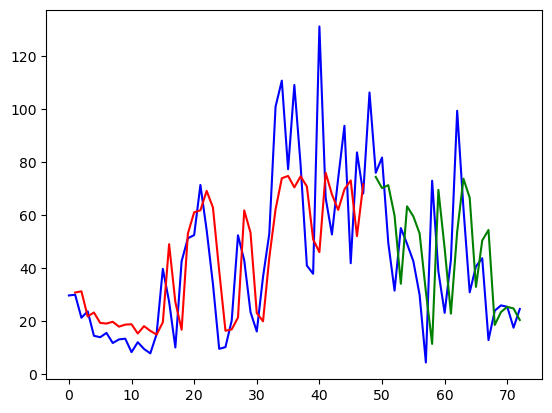

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_excel('wheatdatafix.xlsx')

timeseries = df[['Feed and residual use']].values.astype('float32')
#timeseries

train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c = 'b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()


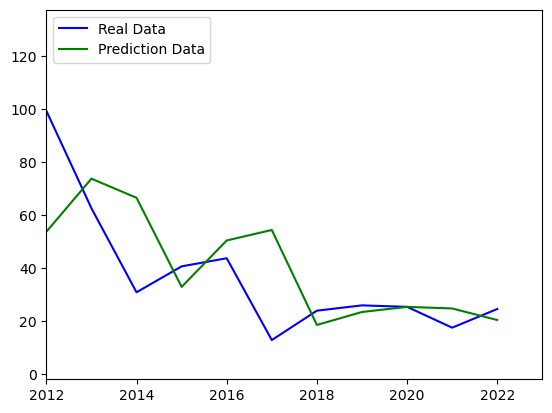

In [2]:
Year = [i for i in range(1950, 2023)]
plt.plot(Year,timeseries, c = 'b', label = "Real Data")
plt.plot(Year,train_plot, c='r')
plt.plot(Year,test_plot, c='g',label = "Prediction Data")
plt.xlim(2012,2023)
plt.legend(loc="upper left")
plt.show()